################## Módulo Aprendizagem ##################

-

1) Encontrar a melhor h(x):

+ (a) Adotar protocolo experimental 5-fold crossvalidation, portanto você encontrará 5 melhores RNAs (1 por fold);

+ (b) Encontrar as 5 melhores redes MLP -- h(x), aquelas que melhor se ajustem a f(x) em cada fold;

+ (c) Salvar todos os melhores modelos, pois o professor irá utilizá-los para criar o ranking dos grupos. Adotar a nomenclatura "NOME_GRUPO_RNA_FOLD_X.pth", onde X={1,2,3,4,5};

    https://pytorch.org/tutorials/beginner/saving_loading_models.html

+ (d) Calcular a diff = abs( y - h(x) ) e plotar igual aula prática II;

+ (e) Plotar o gráfico de linhas para todas as amostras, mostrando o comportamento de h(x) e f(x);

+ (f) Adicionar uma nova coluna na planilha dos dados com o nome de NEW PRICE com os valores estimados pela melhor h(x) encontrada.

-

##################  Módulo Interface ##################

-

2) Construir um MAPA interativo dos EUA:

+ (a) Carregar o mapa do EUA e localizar a região de King County, Washington utilizando qualquer biblioteca de georeferenciamento (Folium, Geopy e GeoPandas);

+ (b) Plotar no mapa 1000 propriedades escolhidas aleatoriamente utilizando das coordenadas Lat/Long presentes na planilha;

+ (c) Mostrar todas os atributos da propriedade (todos os 19) quando passar o mouse em cima do ponto plotado, inclusive deverá mostrar o y e o valor  estimado pela h(x);

-

################## ################## ################## ################## ##################

-

3) Funcionalidades Extras

+ (a) Plotar as casas utilizando a funcionalidade HEATMAP considerando a vetor diff calculado no exercĩcio (1).

+ (b) Adicionar todas as propriedades sem que o site fique LENTO DEMAIS;

+ (c) Colocar diferentes modelos de aprendizagem (árvores de decisão, lineares e redes neurais);

+ (d) Apresentar uma tabela comparativa entre os modelos;

+ (e) Apresentar os dados de forma organizada e bonita;

In [108]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm
import copy
from torchmetrics import MeanAbsolutePercentageError
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
zf = zipfile.ZipFile('/content/drive/MyDrive/Data/House_Sale/House_Sale.zip')  #aloca o arquivo zip

data = pd.read_csv(zf.open('kc_house_data.csv')) # abre o arquivo CSV 'train.csv' presente dentro do ZIP

In [112]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


In [113]:
new_cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'id', 'date', 'lat', 'long', 'zipcode']

data = data[new_cols]

In [114]:
data = data.drop([10, 17])

In [115]:
data.insert(1, 'new_price', None)

In [116]:
data.sample(frac=1)

,price,new_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,id,date,lat,long,zipcode
18569,365650.0,None,4,2.25,2380,7700,2.0,0,0,4,...,0,1977,0,2100,7700,5089700300,20150311T000000,47.4391,-122.194,98055
4407,270000.0,None,4,2.50,1810,6509,2.0,0,0,3,...,0,1994,0,1760,7417,5468730110,20140508T000000,47.3531,-122.143,98042
1834,189650.0,None,2,1.75,1100,7600,1.0,0,0,3,...,0,1980,0,1230,7350,9315300260,20140521T000000,47.4136,-122.318,98198
21529,670000.0,None,3,2.50,3310,5300,2.0,0,2,3,...,870,2008,0,2140,7500,2487200490,20140623T000000,47.5178,-122.389,98136
15831,970000.0,None,4,2.75,3980,9209,2.0,0,0,3,...,0,2002,0,3800,9333,8001470480,20150306T000000,47.6286,-122.064,98074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9331,268500.0,None,4,1.75,1670,8000,1.0,0,0,4,...,0,1974,0,1720,8000,8731982250,20140812T000000,47.3193,-122.383,98023
2609,540000.0,None,4,2.50,1850,7850,2.0,0,0,3,...,0,1985,0,1830,8140,2193340140,20140814T000000,47.6914,-122.103,98052
2326,226740.0,None,3,1.50,1410,8800,1.0,0,0,4,...,0,1965,0,2180,10108,2599200830,20140716T000000,47.2927,-122.183,98092
9643,550000.0,None,3,2.50,2140,10136,1.0,0,0,3,...,820,1958,0,1980,11200,6071000265,20150125T000000,47.5602,-122.184,98006


In [117]:
from sklearn.model_selection import KFold

y = data['price']
X = data.iloc[:, 2:17]

kf = KFold(n_splits=5, shuffle=True)

Fold 1:
	Epoch: 1 ; MSE: 330259398656.0 ; MAPE: 8.906477928161621
	Epoch: 2 ; MSE: 58404130816.0 ; MAPE: 0.3996991217136383
	Epoch: 3 ; MSE: 50123079680.0 ; MAPE: 0.33434897661209106
	Epoch: 4 ; MSE: 44263604224.0 ; MAPE: 0.2889404892921448
	Epoch: 5 ; MSE: 41146007552.0 ; MAPE: 0.2638011872768402
	Epoch: 6 ; MSE: 39945920512.0 ; MAPE: 0.25476741790771484
	Epoch: 7 ; MSE: 39376416768.0 ; MAPE: 0.24860252439975739
	Epoch: 8 ; MSE: 38702510080.0 ; MAPE: 0.2458871603012085
	Epoch: 9 ; MSE: 38311813120.0 ; MAPE: 0.2455006241798401
	Epoch: 10 ; MSE: 38227812352.0 ; MAPE: 0.24130378663539886
	Epoch: 11 ; MSE: 37756694528.0 ; MAPE: 0.24351535737514496
	Epoch: 12 ; MSE: 37810900992.0 ; MAPE: 0.23921045660972595
	Epoch: 13 ; MSE: 37550829568.0 ; MAPE: 0.23784588277339935
	Epoch: 14 ; MSE: 37127147520.0 ; MAPE: 0.24013887345790863
	Epoch: 15 ; MSE: 37159784448.0 ; MAPE: 0.23688818514347076
	Epoch: 16 ; MSE: 36803117056.0 ; MAPE: 0.23834066092967987
	Epoch: 17 ; MSE: 36931035136.0 ; MAPE: 0.23565

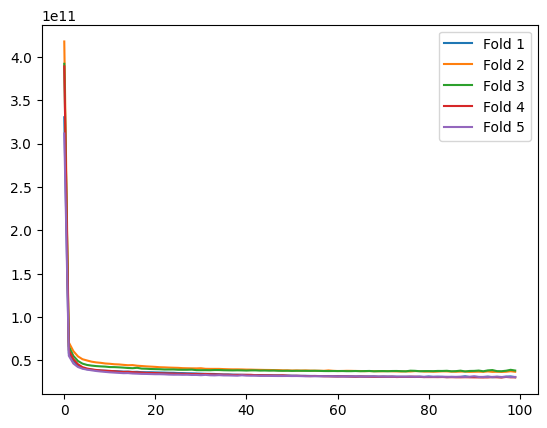

In [142]:
# Fonte: 
#       machinelearningmastery.com/building-a-regression-model-in-pytorch/

best_mse = []
best_mape = []
best_weights = [None, None, None, None, None]
history_mse = [[] for i in range(5)]
history_mape = [[] for i in range(5)]
diff = np.arange(data.shape[0])

for i, (train_index, test_index) in enumerate(kf.split(X)):
  print(f"Fold {i+1}:")
  
  X_train_raw = X.values[train_index]
  y_train = y.values[train_index]
  X_test_raw = X.values[test_index]
  y_test = y.values[test_index]

  scaler = StandardScaler()
  scaler.fit(X_train_raw)
  X_train = scaler.transform(X_train_raw)
  X_test = scaler.transform(X_test_raw)

  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
  
  model = nn.Sequential(
    nn.Linear(15, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
  )

  loss_fn = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  scheduler = CosineAnnealingWarmRestarts(optimizer, 
                                        T_0 = 10,# Number of iterations for the first restart
                                        T_mult = 1, # A factor increases TiTi​ after a restart
                                        eta_min = 0.0001) # Minimum learning rate

  n_epochs = 100
  batch_size = 128
  batch_start = torch.arange(0, len(X_train), batch_size)

  for k in range(5):
    best_mse.append(np.inf)
    best_mape.append(np.inf)

  for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        for start in bar:
        
          X_batch = X_train[start:start+batch_size]
          y_batch = y_train[start:start+batch_size]

          y_pred = model(X_batch)

          loss = loss_fn(y_pred, y_batch)
          
          optimizer.zero_grad()
          loss.backward()
          
          optimizer.step()

          scheduler.step()

    model.eval()
    y_pred = model(X_test)

    mape = MeanAbsolutePercentageError()
    mape_f = mape(y_test, y_pred).detach().numpy()

    mse = loss_fn(y_pred, y_test)
    mse = float(mse)

    history_mse[i].append(mse)
    history_mape[i].append(mape_f)


    print(f"\tEpoch: {epoch+1} ; MSE: {mse} ; MAPE: {mape_f}")

    if mape_f < best_mape[i]:
        best_mape[i] = mape_f
        best_weights[i] = copy.deepcopy(model.state_dict())

    if mse < best_mse[i]:
        best_mse[i] = mse

  model.load_state_dict(best_weights[i])

  torch.save(model.state_dict(), 'MURILO_CAPOZZI_RNA_FOLD_'+str(i+1)+'.pth')

  model.eval()
  with torch.no_grad():
    X_pred = model(X_test)
    for i in range(len(test_index)):
      if test_index[i] in data.index:
        diff[i] = abs(y_test[i].numpy() - X_pred[i][0].numpy())
        data.loc[test_index[i], 'new_price'] = X_pred[i][0].numpy()


plt.plot(history_mse[0], label='Fold 1')
plt.plot(history_mse[1], label='Fold 2')
plt.plot(history_mse[2], label='Fold 3')
plt.plot(history_mse[3], label='Fold 4')
plt.plot(history_mse[4], label='Fold 5')
plt.legend(['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5'])
plt.show()


In [158]:
print("RNA:\nFold\tMAPE\t\t\tMSE\t\tRMSE")
for i in range(5):
  print(f"{i+1}\t{best_mape[i]}\t{best_mse[i]}\t{np.sqrt(best_mse[i])}")

RNA:
Fold	MAPE			MSE		RMSE
1	0.2247627228498459	30709030912.0	175239.92385298506
2	0.22751489281654358	36811071488.0	191862.11582279604
3	0.23566745221614838	37378199552.0	193334.4241256585
4	0.22436407208442688	30415173632.0	174399.4656872549
5	0.23339681327342987	30944481280.0	175910.4353925599


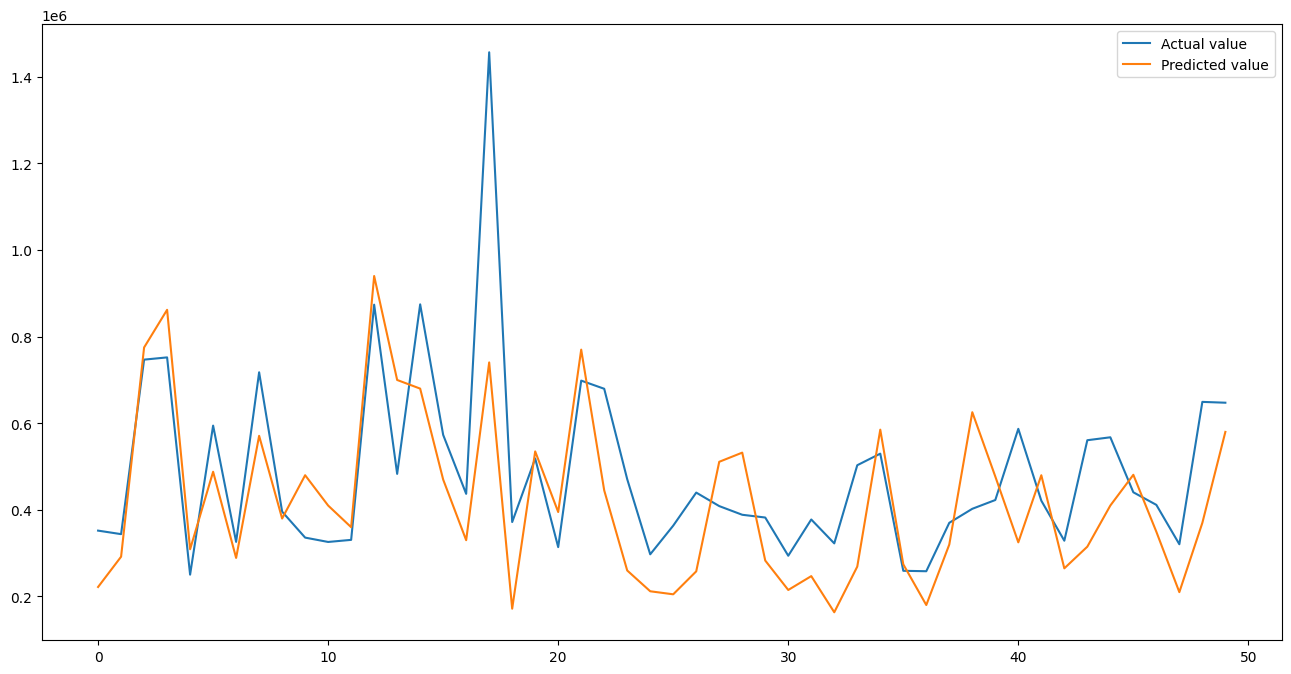

In [157]:
rna_outcomes = pd.DataFrame({'Predicted value':list(X_pred.detach().numpy()), 'Actual value':list(y_test.detach().numpy())}, index=np.arange(len(y_test)))
fig= plt.figure(figsize=(16,8))
rna_outcomes = rna_outcomes.reset_index()
rna_outcomes = rna_outcomes.drop(['index'],axis=1)
plt.plot(rna_outcomes[:50])
plt.legend(['Actual value','Predicted value'])

plt.show()

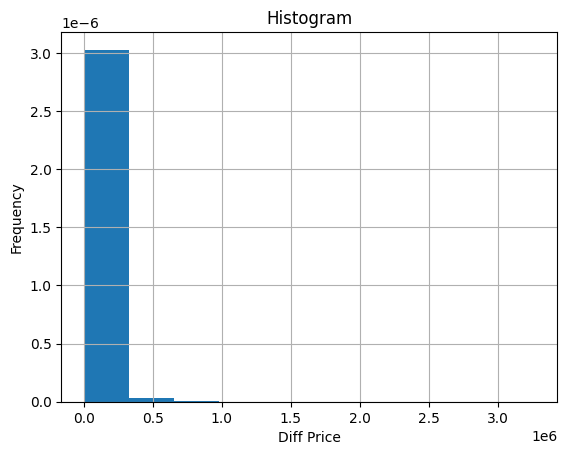

In [200]:
n, bins, patches = plt.hist(diff, density=True)
plt.xlabel('Diff Price')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.grid(True)
plt.show()

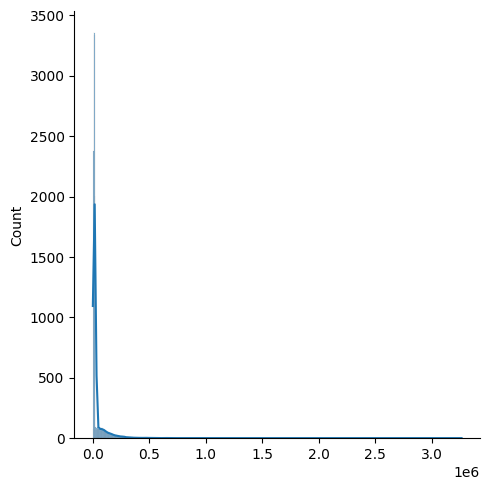

In [201]:
sns.displot(diff, bins=1000, kde=True);

In [168]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import linear_model
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [189]:
#arvore de decisao
from sklearn import tree


clf = tree.DecisionTreeRegressor(random_state=0,max_depth=5)
clf = clf.fit(X_train, y_train)

dt_predicao = clf.predict(X_test)

In [185]:
#regressao linear
regr = linear_model.LinearRegression()

regr.fit(X_train, y_train)

regr_predicao = regr.predict(X_test)

In [161]:
# Comparando os modelos de treinamento

print("Modelo \t| MAPE \t\t\t| MSE \t\t\t| RMSE")
print(f"DT \t| {metrics.mean_absolute_percentage_error(y_test, dt_predicao)} \t| {metrics.mean_squared_error(y_test, dt_predicao)} \t| {np.sqrt(metrics.mean_squared_error(y_test, dt_predicao))}")
print(f"Linear \t| {metrics.mean_absolute_percentage_error(y_test, regr_predicao)} \t| {metrics.mean_squared_error(y_test, regr_predicao)} \t| {np.sqrt(metrics.mean_squared_error(y_test, regr_predicao))}")

Modelo 	| MAPE 			| MSE 			| RMSE
DT 	| 0.30083839119796435 	| 50857985277.3515 	| 225517.15073881077
Linear 	| 0.2893701493740082 	| 45605666816.0 	| 213554.828125


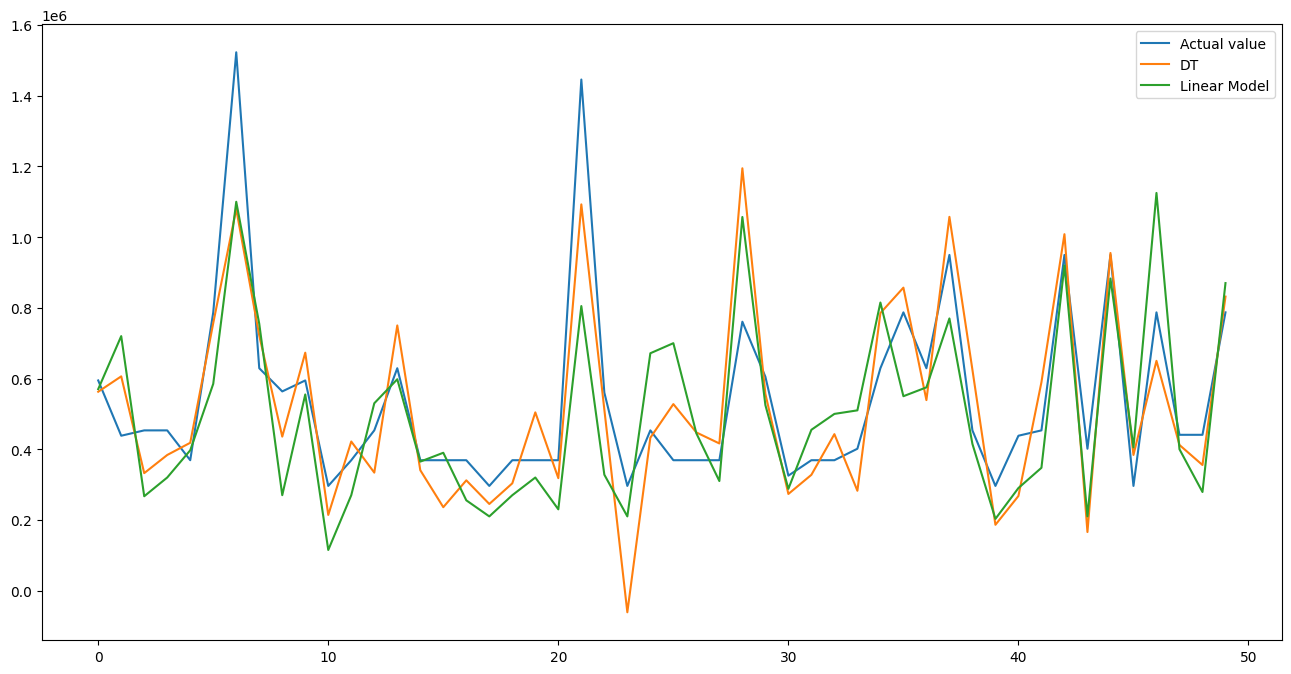

In [191]:
model_outcomes = pd.DataFrame({'DT':dt_predicao, 'Linear Model':regr_predicao, 'Actual value':y_test})
fig= plt.figure(figsize=(16,8))
model_outcomes = model_outcomes.reset_index()
model_outcomes = model_outcomes.drop(['index'],axis=1)
plt.plot(model_outcomes[:50])
plt.legend(['Actual value','DT','Linear Model'])

plt.show()

In [135]:
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

In [192]:
def normalizar(x, min, max):
  return (x-min)/(max-min)

In [199]:
colrGradient = {0.0: 'blue',
                0.6: 'cyan',
                0.7: 'lime',
                0.8: 'yellow',
                1.0: 'red'}


mapObj = folium.Map(location=[47.4269989,-122.9248411], zoom_start=5)

layer1 = folium.GeoJson(
    data=(open("washington.geojson", 'r').read()),
    name="Washington")

layer1.add_to(mapObj)

folium.TileLayer('openstreetmap').add_to(mapObj)
folium.TileLayer('stamenterrain', attr="stamenterrain").add_to(mapObj)
folium.TileLayer('stamenwatercolor', attr="stamenwatercolor").add_to(mapObj)
folium.TileLayer('https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png', name='CartoDB.DarkMatter', attr="CartoDB.DarkMatter").add_to(mapObj)

mapHeat = []
marker_cluster = MarkerCluster(overlay=True, control=False, icon_create_function=None)

for i in range(data.shape[0]):
  if i in data.index:
    mark = data.loc[i]

    mapHeat.append([mark['lat'], mark['long'], normalizar(mark['new_price'], min(diff), max(diff))])

    marker = folium.Marker(location=[mark['lat'], mark['long']],
                  icon=folium.Icon(icon='home',prefix='fa'),
                  popup=folium.Popup(f"<b>Price:</b> U${mark['price']}<br> \
                                      <b>New_price:</b> U${mark['new_price']}<br> \
                                      <b>Bedrooms:</b> {mark['bedrooms']}<br> \
                                      <b>Bathrooms:</b> {mark['bathrooms']}<br> \
                                      <b>Living area:</b> {mark['sqft_living']}m2<br> \
                                      <b>Lot area:</b> {mark['sqft_lot']}m2<br> \
                                      <b>Floors:</b> {mark['floors']}<br> \
                                      <b>Waterfront:</b> {mark['waterfront']}<br> \
                                      <b>View:</b> {mark['view']}<br> \
                                      <b>Condition:</b> {mark['condition']}<br> \
                                      <b>Grade:</b> {mark['grade']}<br> \
                                      <b>Above:</b> {mark['sqft_above']}m2<br> \
                                      <b>Basement:</b> {mark['sqft_basement']}m2<br> \
                                      <b>Year built:</b> {mark['yr_built']}<br> \
                                      <b>Year renovated:</b> {mark['yr_renovated']}<br> \
                                      <b>Living area(15):</b> {mark['sqft_living15']}m2<br> \
                                      <b>Lot area(15):</b> {mark['sqft_lot15']}m2<br> \
                                      <b>Zipcode:</b> {mark['zipcode']}<br> \
                                      ", max_width=500))

    marker_cluster.add_child(marker)

HeatMap(mapHeat, gradient=colrGradient).add_to(mapObj)

marker_cluster.add_to(mapObj)

folium.LayerControl().add_to(mapObj)

mapObj.save('map.html')